# Zonal Statistics

In this tutorial, you'll learn how to use [xarray-spatial](https://xarray-spatial.org/) to work with zonal statistics. Zonal statistics help you better understand data from one source by analyzing it for different zones defined by another source. This operation uses two datasets: One dataset, the *zones raster*, defines one or more zones. A second dataset, the *values raster*, contains the data you want to analyze for each of the zones defined by the first dataset.

In this example, you will use three datasets: [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem), [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), and [Esri 10m Land Use/Land Cover](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac). As your *zones raster*, you will generate five elevation classes from the NASADEM dataset and use those classes as the different zones to analyze data for. The remaining two datasets are used as *value rasters*: You will analyze [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) data from the Sentinel-2 dataset and [land use classes](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) from the Esri dataset.

This tutorial covers the following steps:

- Load and align [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem), [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), and [Esri 10m Land Cover](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) data.
- Classify the [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) data into elevation zones.
- Compute [zonal statistics](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) using the elevation zones from the NASADEM data and [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) values based on [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data.
- Compute [cross-tabulation statistics](https://en.wikipedia.org/wiki/Contingency_table) using the NASADEM-based elevation zones and land cover values from the [Esri Land Cover](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) data.

In [1]:
import numpy as np
import xarray as xr

import planetary_computer as pc
import pystac_client
import stackstac

import matplotlib as mpl
import matplotlib.pyplot as plt

from xrspatial import hillshade
from xrspatial.multispectral import true_color, ndvi
from xrspatial.classify import equal_interval, quantile
from xrspatial import zonal_stats, zonal_crosstab

## Preparation: Create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to process the data in parallel using all the cores of your machine.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

## Load and coregister data

The area of interest covers Lake Bridgeport, Texas, USA. Select the corresponding NASADEM scene and then load and process Sentinel and Esri Land Cover data that overlaps this NASADEM scene.

#### NASADEM data

Use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to identify a GeoTIFF that covers Lake Bridgeport.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-97.807733, 33.2133019]}

nasadem_search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
nasadem_item = next(nasadem_search.get_items())

nasadem_item

<Item id=NASADEM_HGT_n33w098>

Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load the NASADEM data, reproject it to the [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection, and resample it to a resolution of 100m. These three operations all happen in a single step. See [Reprojecting](reprojection.ipynb) to learn more about reprojecting and resampling.

In [4]:
nasadem_data = (
    stackstac.stack(
        [pc.sign(nasadem_item).to_dict()],
        epsg=3857,  # reproject to Web Mecator
        resolution=100 # resolution of output image
    ).where(lambda x: x > 0, other=np.nan)
).isel(time=0, band=0).persist()
  
# assign name for the data array
nasadem_data.name = 'Elevation (NASADEM)'

nasadem_data.spec, nasadem_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (1337, 1115))

#### Sentinel data

Use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to search for all Sentinel images that match the following criteria:
* overlap with the NASADEM scene you just selected
* have a cloud coverage of less than 10 percent
* are from July 2020

In [5]:
sentinel_search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=nasadem_item.geometry,
    datetime="2020-07-01/2020-07-30",
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

sentinel_items = [pc.sign(item).to_dict() for item in sentinel_search.get_items()]
len(sentinel_items)

15

To align data from different datasets that initially have different reprojection and resolution settings, both data sets need to use the same resolution and the same [Coordinate Reference System(CRS)](https://gdal.org/tutorials/osr_api_tut.html). 
Load the Sentinel data with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) and set the `resolution`, `epsg`, and `bounds` properties to match those of your NASADEM data.

In [6]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_items,
            resolution=nasadem_data.resolution,  # resample to Nasadem data resolution
            epsg=nasadem_data.spec.epsg,  # reporoject to CRS of Nasadem data
            bounds=nasadem_data.spec.bounds,  # set bounds to match Nasadem data
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0, other=np.nan)  # Sentinels uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)

sentinel_data.spec, sentinel_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (4, 1337, 1115))

#### Esri land cover data

Similarly, use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to search for all Esri 10m Land Cover images that overlap with the selected NASADEM scene.

In [7]:
io_lulc_search = catalog.search(
    collections=["io-lulc"],
    intersects=nasadem_item.geometry,
)

io_lulc_items = [pc.sign(item).to_dict() for item in io_lulc_search.get_items()]
len(io_lulc_items)

4

Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load Esri's land cover data and align it to match your NASADEM data.

In [8]:
landcover_data = (
    stackstac.stack(
        io_lulc_items,
        resolution=nasadem_data.resolution,  # resample to Nasadem data resolution
        epsg=nasadem_data.spec.epsg,  # reporoject to CRS of Nasadem data
        bounds=nasadem_data.spec.bounds,  # set bounds to match Nasadem data
        assets=["data"],
    )
    .median(dim="time", keep_attrs=True)
    .sel(band="data")  # data band
    .persist()
)

landcover_data.name = "Land Cover (Esri)"

landcover_data.spec, landcover_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (1337, 1115))

#### Visualize aligned data

To make visualizing multiple datasets easier, define a helper function that generates a layout of multiple images:

In [9]:
# helper function
def plot_imgs(imgs, cmaps=[], cats=[], figsize=(15, 7)):
    
    n_imgs = len(imgs)
    n_cmaps = len(cmaps)
    
    gridspec_kw = {
        "width_ratios": [*[1 for _ in range(n_imgs)], *[0.08 for _ in range(n_cmaps)]],
    }    
    fig, ax = plt.subplots(nrows=1, ncols=n_imgs+n_cmaps, figsize=figsize, gridspec_kw=gridspec_kw)
        
    im = []
    for i, img in enumerate(imgs):
        if i < n_cmaps:
            im.append(ax[i].imshow(img.data, cmap=cmaps[i]))
        else:
            im.append(ax[i].imshow(img.data))            
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(img.name)
        
    for i in range(n_cmaps):
        cmap = plt.get_cmap(cmaps[i])
        if i < len(cats):
            bounds = [-1, *cats[i]]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax[n_imgs+i])
            cbar.ax.set_yticklabels(['', *cats[i]])
        else:
            cbar = fig.colorbar(im[i], cax=ax[n_imgs+i])        
        cbar.set_label(imgs[i].name)
        
    fig.tight_layout()
    plt.show()

Render the NASADEM image with [xrspatial.hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html):

In [10]:
hillshaded_nasadem_data = hillshade(
    nasadem_data,
    azimuth=100,
    angle_altitude=50,
    name='Hillshaded Elevation (NASADEM)'
)

Create a true color image for the Sentinel data:

In [11]:
sentinel_img = true_color(
    sentinel_data.sel(band='red'),
    sentinel_data.sel(band='green'),
    sentinel_data.sel(band='blue'),
    c=30, th=0.075,
    name='True color (Sentinel)'
)

Use the helper function you defined earlier to plot a layout of images based on the NASADEM, Esri Land Cover, and Sentinel data:

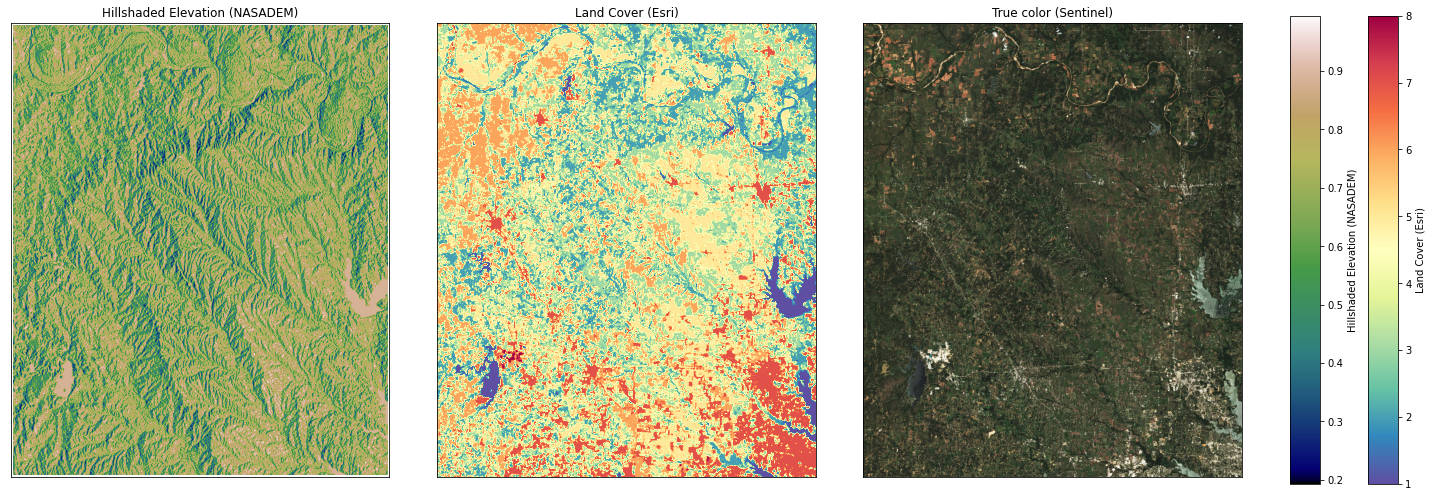

In [12]:
plot_imgs(
    imgs=[hillshaded_nasadem_data, landcover_data, sentinel_img],
    cmaps=['gist_earth', 'Spectral_r'],
    figsize=(20, 7)
)

## Create a zone raster

Zonal statistics operations are based on zones defined in a *zone raster*. The zone raster for the following examples consists of five distinctive zones that are based on the NASADEM elevation dataset. To define the different zones, classify the elevation data into different elevation categories. The zones in your zone raster correspond to these elevation classes. 

Divide the NASDEM elevation data into five quantile groups of equal size:

In [13]:
quantile_zones = equal_interval(
    nasadem_data,
    k=5,
    name='Zones (Classified Elevation - NASADEM)'
)

## Compute zonal statistics

In addition to the zonal raster you just defined based on the NASADEM data, zonal statistics require a *value raster*. In this example, use the Sentinel data as a value raster.

First, compute NDVI values from the Sentinel data you prepared earlier:

In [14]:
ndvi_values = ndvi(
    sentinel_data.sel(band='nir'),
    sentinel_data.sel(band='red'),
    name='Values (NDVI - Sentinel)'
)

Next, plot both the five NASADEM elevation classes and the Sentinel-based NDVI data next to each other:

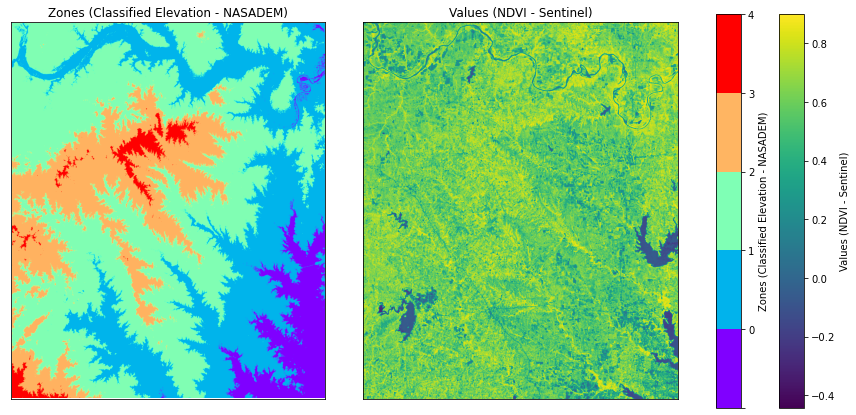

In [15]:
plot_imgs(
    imgs=[quantile_zones, ndvi_values],
    cmaps=['rainbow', 'viridis'],
    cats=[[0, 1, 2, 3, 4]],
    figsize=(12, 6)
)

Finally, use the [xrspatial.zonal_stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) function to combine data from your zone raster (the NASADEM-based elevation zones) and your value raster (the Sentinel-based NDVI data). For each of the five elevation zones in the zonal raster, this function calculates various statistics based on the NDVI data in the value raster. The function returns a DataFrame where each row represents a zone. The columns of the DataFrame contain the following seven statistics calculated from the NDVI data:

1. Mean
2. Max
3. Min
4. Sum
5. Std
6. Var
7. Count

This example considers three of those statistics, mean, max, and min:

In [16]:
quantile_stats = zonal_stats(
    zones=quantile_zones,
    values=ndvi_values,
    stats_funcs=['mean', 'max', 'min']
)

quantile_stats.compute()

,zone,mean,max,min
0,0,0.440738,0.900511,-0.419831
1,1,0.585294,0.899222,-0.443129
2,2,0.579834,0.893552,-0.414806
3,3,0.603123,0.888252,-0.351653
4,4,0.614063,0.875973,-0.183576


## Compute zonal cross-tabulation statistics

The [xrspatial.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) function calculates cross-tabulated areas between the zone raster and value raster. This function requires a 2D zone raster and a categorical value raster of 2D or 3D data. 

The `crosstab` function calculates different cross-tabulation statistics. It has an `agg` parameter to define which aggregation method to use. It returns a DataFrame where each row represents a zone from the zone raster and each column represents a category from the value raster. 

This example uses the NASADEM elevation zones from earlier as its zone raster. It uses the Esri Land Cover data as its categorical value raster. The resulting DataFrame will show the percentage of each land cover category for each of the five elevation zones. For each of the elevation categories, you will be able to see what percentage of the land is covered in trees, grass, or water, for example.

First, identify all land cover classes contained in the Esri data you prepared earlier:

In [17]:
# create list of names of land cover classes
class_names = landcover_data.coords["label:classes"].item()["classes"]

# create dict of classes that are available in the data
landcover_data_classes = {
    i: class_names[int(i)] for i in np.unique(landcover_data.data).compute()
}

landcover_data_classes

{1.0: 'water',
 2.0: 'trees',
 3.0: 'grass',
 4.0: 'flooded veg',
 5.0: 'crops',
 6.0: 'scrub',
 7.0: 'built area',
 8.0: 'bare'}

The Esri data for the area of interest contains eight different land cover classes. See the [Esri 2020 Land Cover webpage at arcgis.com](https://www.arcgis.com/home/item.html?id=d6642f8a4f6d4685a24ae2dc0c73d4ac) for more information about the class definitions used in this dataset.

Next, plot both the five NASADEM elevation classes and Esri's eight landcover classes next to each other:

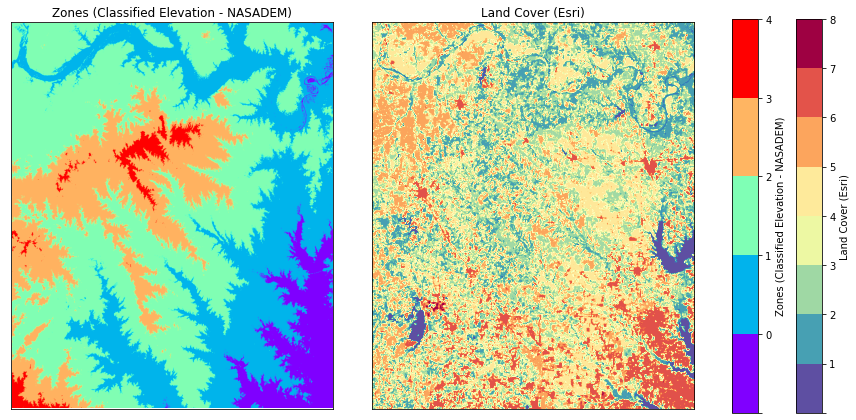

In [18]:
plot_imgs(
    imgs=[quantile_zones, landcover_data],
    cmaps=['rainbow', 'Spectral_r'],
    cats=[[0, 1, 2, 3, 4], [1, 2, 3, 4, 5, 6, 7, 8]],
    figsize=(12, 6)
)

Finally, calculate the cross-tabulation statistics and display a table demonstrating how the land cover categories are distributed over each of the five elevation zones:

In [19]:
crosstab_elev_landcover = zonal_crosstab(
    zones=quantile_zones,
    values=landcover_data,
    agg='percentage',
)

# rename the columns to match Land Cover class definition
crosstab_elev_landcover.columns = ['zone', *landcover_data_classes.values()]

crosstab_elev_landcover.compute()

,zone,water,trees,grass,flooded veg,crops,scrub,built area,bare
0,0,19.194996,16.619237,10.637621,0.399138,7.483612,7.121751,38.353624,0.190022
1,1,2.032851,23.408673,22.159019,0.109825,20.203309,13.815892,17.736924,0.533506
2,2,2.079317,20.613488,23.654159,0.091228,16.643155,27.866330,8.754948,0.297375
3,3,0.597121,27.804316,21.287271,0.029408,14.039335,28.293848,7.857609,0.091092
4,4,0.220107,34.809348,19.252929,0.003237,6.179193,32.320192,6.758594,0.456399
